### I this notebook I will check the distribution of the found entities with respect to the labels, what are the most frequent sources / telescopes in each citation class and the amount of missing etities per class and make the corresponding conclusions

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [34]:
df_ner = pd.read_csv("../ner/name_entities.csv", index_col=0)
df_ner['telescope'] = df_ner['telescope'].apply(ast.literal_eval)
df_ner['source'] = df_ner['source'].apply(ast.literal_eval)

lables = pd.read_csv("../data/labels.csv", index_col=0)

df_date = pd.read_csv("../data/assembled.csv", index_col=0)[['date']]
df_date['date'] = pd.to_datetime(df_date['date'])

In [35]:
df = df_date.join(df_ner.join(lables))

In [36]:
df.tail(10)

,date,telescope,source,n_cited,citation_class
telegram_index,,,,,
16028_atel,2023-05-05,[telescope not found],[source not found],0,0
16029_atel,2023-05-05,"[swift, rosat, neil gehrels swift observatory]",[source not found],0,0
16030_atel,2023-05-06,"[most, fast]","[sao, blazar]",0,0
16031_atel,2023-05-08,"[swift, rosat, neil gehrels swift observatory]",[source not found],0,0
16032_atel,2023-05-08,[telescope not found],[source not found],0,0
16033_atel,2023-05-10,"[gamma, fermi]","[radio source, blazar]",0,0
16034_atel,2023-05-12,"[shane telescope, atlas, lick]","[atlas, galaxy, supernova]",0,0
16035_atel,2023-05-12,"[gamma, fermi]",[quasar],0,0
16036_atel,2023-05-12,[most],[source not found],0,0


In [37]:
# % of the telegrams without any entities found
df_e = df.explode('telescope').explode("source")
df_e[(df_e.telescope == 'telescope not found') & (df_e.source == 'source not found')].shape[0]/len(df)

0.031815074877275834

In [38]:
df_c = df.copy()
df_c['n_found_ents'] = df_c.apply(lambda x: len(set([y for y in x.telescope + x.source 
                                             if y != 'telescope not found' and y != 'source not found'])), axis=1)

In [39]:
df_c.n_found_ents.mean()

3.08724290064003

#### - is here any correlation between amount of entities found and the citation rate?

In [40]:
df['found_telescopes'] = df['telescope'].apply(len)
df['found_sources'] = df['source'].apply(len)

In [41]:
plt.rcParams["figure.figsize"] = (16, 8)

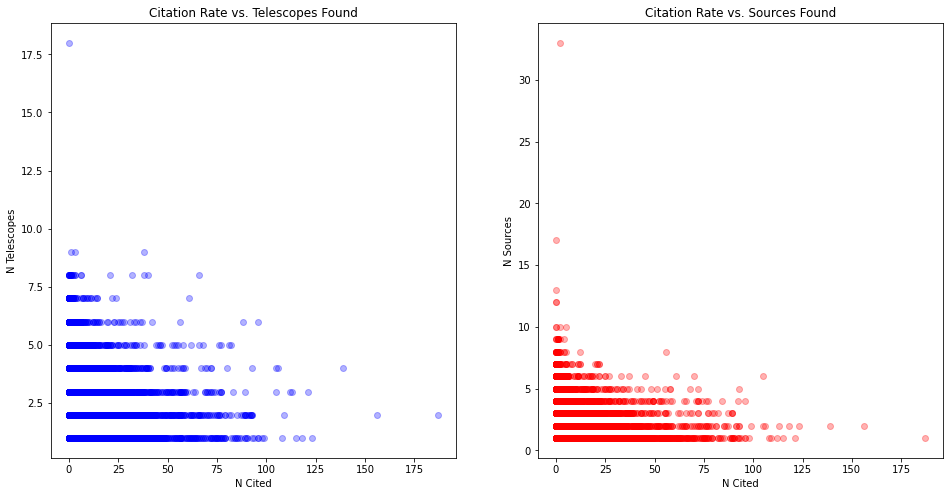

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(df.n_cited.values, df["found_telescopes"], color='blue', label='telescopes', alpha=0.3)
ax[1].scatter(df.n_cited.values, df["found_sources"], color='red', label='sources', alpha=0.3)
for a, l in zip(ax, ['Telescopes', 'Sources']):
    # a.legend()
    a.set_title(f"Citation Rate vs. {l} Found")
    a.set_xlabel("N Cited")
    a.set_ylabel(f"N {l}")
fig.show()

There is no correlation between the amount of entities we are able to find and the interest to the telegrams

#### - what is the relation between amount of entities found and time?

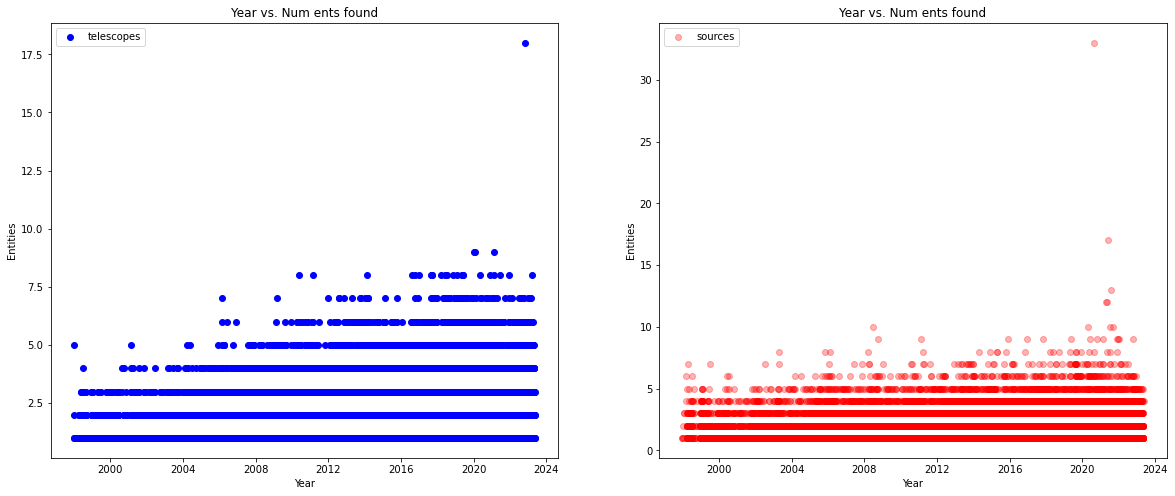

In [43]:
plt.rcParams["figure.figsize"] = (20, 8)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(df.date.values, df["found_telescopes"], color='blue', label='telescopes')
ax[1].scatter(df.date.values, df["found_sources"], color='red', label='sources', alpha=0.3)
for a in ax:
    a.legend()
    a.set_title("Year vs. Num ents found")
    a.set_xlabel("Year")
    a.set_ylabel("Entities")
fig.show()

Our NER training data contained more new telescopes. The sources we are getting thru years dont seem to change that much, though.

#### - check the citation rate and no found entities relation

In [44]:
df['no_telescopes_found'] = df['telescope'].apply(lambda x: x[0] == 'telescope not found').astype(np.int32)
df['no_sources_found'] = df['source'].apply(lambda x: x[0] == 'source not found').astype(np.int32)

In [45]:
df_n = df.groupby('citation_class').agg({"no_telescopes_found": "sum", "no_sources_found": "sum", "date": "count"})
df_n['missing_telescopes_by_class'] = round(df_n['no_telescopes_found']/df_n['date'] * 100, 2).apply(lambda x: str(x)+'%')
df_n['missing_sources_by_class'] = round(df_n['no_sources_found']/df_n['date'] * 100, 2).apply(lambda x: str(x)+'%')

In [46]:
df_n[['missing_telescopes_by_class', 'missing_sources_by_class']]

,missing_telescopes_by_class,missing_sources_by_class
citation_class,,
0,19.01%,11.74%
1,13.9%,11.97%
2,11.2%,19.71%


We know more about interesting telescopes rather than interesting sources. It means that we can extract the telescopes capable to find rare things in the cosmos which will make the observation likely more cited in the future. The amount of such potent telescopes is limited and there's no wonder why we can catch most of them - we have seen them pretty often in the training data (the largest observatories and institutes are operating with these telescopes). And vice versa, the are much more amateur telescopes capable to find only the generic things (class 0) which we are missing. 

However, the amount of rare (and interesting) sources is much larger, and so we are not able to catch all of them. The training data contained  mostly of the well-known source labels e.g. most popular starts, black holes etc.. 

#### - check the most frequent telescopes and sources with relation to the citation classes

In [47]:
telescopes_by_class = []
sources_by_class = []

for i, g in df.groupby("citation_class"):
    g_telescope = g.explode(column='telescope')
    g_telescope = g_telescope[g_telescope.telescope != 'telescope not found']
    
    g_source = g.explode(column='source')
    g_source = g_source[g_source.source != 'source not found']

    
    top_10_telescope = g_telescope.telescope.value_counts().iloc[:10].reset_index()
    top_10_telescope['class'] = i
    
    top_10_source = g_source.source.value_counts().iloc[:10].reset_index()
    top_10_source['class'] = i
    
    telescopes_by_class.append(top_10_telescope)
    sources_by_class.append(top_10_source)

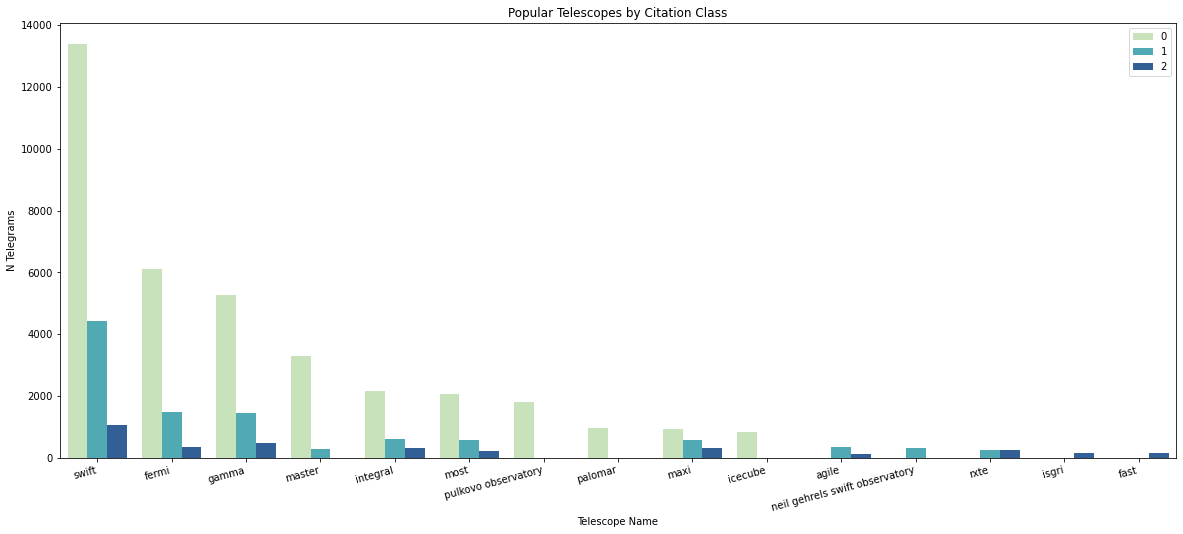

In [56]:
sns.barplot(x='index', y='telescope', data=pd.concat([pd.DataFrame(telescopes_by_class[i]) for i in range(3)]), hue='class',
           palette='YlGnBu')
plt.xticks(rotation=15, ha='right')
plt.legend(loc='upper right')
plt.title("Popular Telescopes by Citation Class")
plt.xlabel("Telescope Name")
plt.ylabel("N Telegrams")
plt.show()

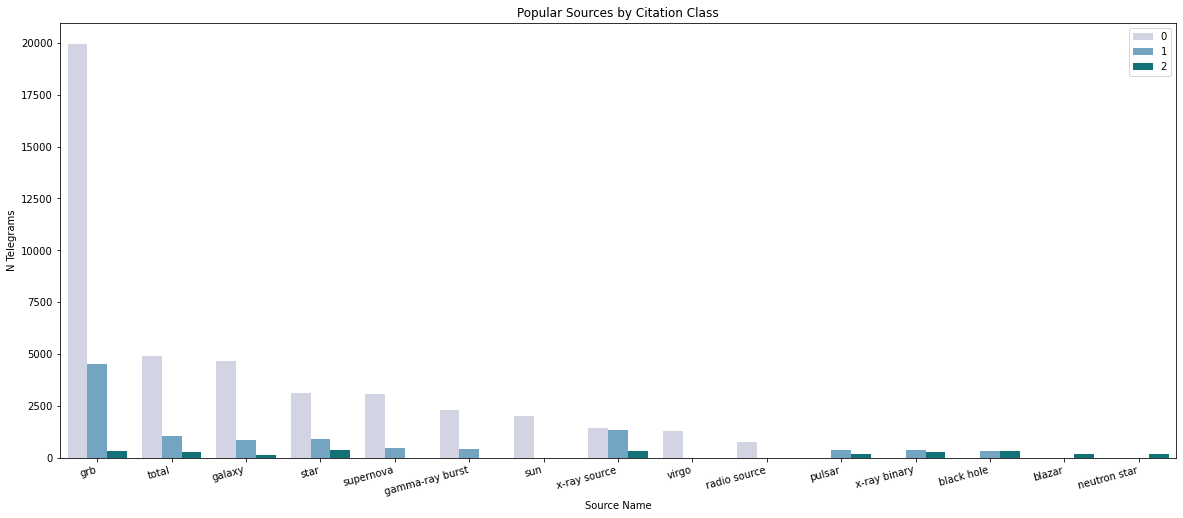

In [62]:
sns.barplot(x='index', y='source', data=pd.concat([pd.DataFrame(sources_by_class[i]) for i in range(3)]), hue='class',
           palette='PuBuGn')
plt.xticks(rotation=15, ha='right')
plt.legend(loc='upper right')
plt.title("Popular Sources by Citation Class")
plt.xlabel("Source Name")
plt.ylabel("N Telegrams")
plt.show()

We can notice that some entities are more common for the less interesting telegrams, f.i. palomar and icecube telescopes, sun and virgo sources. At the same time, there are entities which can help us to identify more cited telegrams, such as the black holes or neuron stars sources or 'isgri' and 'fast' telescopes. This entitiy-based class separatability is an indicator that extracted entities will have an impact on the citation prediction problem.